In [1]:
import torch
import spacy
import nltk

print(torch.__version__)
print(spacy.__version__)
print(nltk.__version__)

2.8.0+cu126
3.8.7
3.9.1


In [2]:
from pathlib import Path
import requests
import zipfile

data_path = Path("data")
image_path = data_path / "SPAM_DATASET"

if image_path.exists():
  print(f"{image_path} exists")
else:
  print(f"{image_path} downloading")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "SPAM_DATASET.zip", "wb") as f:
    request = requests.get("https://github.com/Shaheed-colab/NLP/raw/refs/heads/main/SPAM_DATASET.zip")
    print("Downloading...")
    f.write(request.content)
  with zipfile.ZipFile(data_path / "SPAM_DATASET.zip", 'r') as zip_ref:
    print("Unizipping...")
    zip_ref.extractall(image_path)

data/SPAM_DATASET downloading
Downloading...
Unizipping...


In [3]:
import pandas as pd
df = pd.read_csv('data/SPAM_DATASET/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.head(10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['v2'], df['v1'], test_size=0.2, random_state=42) # Split v2 (text) as X and v1 (labels) as y

In [9]:
vocab = set()
for text in df['v2']:
  for word in text.split():
    vocab.add(word)

print(f"Vocab size: {len(vocab)}")

Vocab size: 15585


In [10]:
# from spacy.lang.en.stop_words import STOP_WORDS
# nlp = spacy.load("en_core_web_sm")
# def preprocess(text):
#   doc = nlp(text)
#   filtered_tokens = []
#   for token in doc:
#     if token.is_stop or token.is_punct:
#       continue
#     filtered_tokens.append(token.lemma_)
#     return " ".join(filtered_tokens)

In [11]:
# import tqdm
# from tqdm.auto import tqdm

# tqdm.pandas()
# df['v2'] = df['v2'].progress_apply(lambda x: preprocess(x))
# df.head(10)

In [14]:
from tqdm.auto import tqdm
tqdm.pandas()
df['v1'] = df['v1'].progress_apply(lambda x: 1 if x == 'spam' else 0)

  0%|          | 0/5572 [00:00<?, ?it/s]

In [15]:
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
from torch.nn.utils.rnn import pad_sequence

pd1 = torch.tensor([1, 2, 3])
pd2 = torch.tensor([4, 5, 6])
pd3 = torch.tensor([7, 8, 9])

sequence = [pd1, pd2, pd3]
sequence = pad_sequence(sequence, batch_first=True)

In [19]:
sequence

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [20]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [22]:
print(X_train.shape)
print(X_test.shape)

(4457, 7735)
(1115, 7735)


In [23]:
from torch.utils.data import Dataset, DataLoader
import torch # Import torch to convert to tensor

class SpamDataset(Dataset):
  def __init__(self, text, labels):
    self.text = text
    self.labels = labels

  def __len__(self):
    return self.text.shape[0] # Use shape[0] to get the number of samples

  def __getitem__(self, idx):
    # Convert the sparse matrix slice to a dense tensor
    text_tensor = torch.tensor(self.text[idx].todense()).squeeze(0).float() # Convert to dense and then tensor

    # Convert label string to integer
    label = 1 if self.labels.iloc[idx] == 'spam' else 0
    label_tensor = torch.tensor(label).long() # Ensure label is long tensor

    return text_tensor, label_tensor

train_dataset = SpamDataset(X_train, y_train)
test_dataset = SpamDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [24]:
import torch
import torch.nn as nn

class LSTM_MODEL(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, batch_first):
    super(). __init__()
    # Since we are using TF-IDF, we don't need an embedding layer.
    # We'll use a linear layer to process the input features before the LSTM.
    self.fc_in = nn.Linear(input_size, hidden_size) # Add a linear layer
    self.relu = nn.ReLU()
    self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=batch_first) # LSTM input size is now hidden_size
    self.fc_out = nn.Linear(hidden_size, output_size) # Output linear layer
  def forward(self, x):
    # x is already a dense tensor from TF-IDF
    x = self.fc_in(x) # Pass through the initial linear layer
    x = self.relu(x)
    # LSTM expects input shape (batch_size, sequence_length, input_size)
    # Since TF-IDF is 2D (batch_size, input_size), we need to add a sequence_length dimension
    # Assuming each sample is a sequence of length 1 for simplicity with TF-IDF
    x = x.unsqueeze(1) # Add sequence length dimension
    x, _ = self.lstm(x)
    # LSTM output shape is (batch_size, sequence_length, hidden_size)
    # We take the output from the last time step
    x = x[:, -1, :] # Take the output from the last time step
    x = self.relu(x)
    x = self.fc_out(x) # Pass through the output linear layer
    return x

In [25]:
model_0 = LSTM_MODEL(input_size=X_train.shape[1], # Set input_size to the number of features from TF-IDF
                     hidden_size=20,
                     output_size=2,
                     batch_first=True)

In [26]:
model_0.to(device)

LSTM_MODEL(
  (fc_in): Linear(in_features=7735, out_features=20, bias=True)
  (relu): ReLU()
  (lstm): LSTM(20, 20, batch_first=True)
  (fc_out): Linear(in_features=20, out_features=2, bias=True)
)

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [28]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [29]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.2f}")
  return total_time

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  train_loss = 0
  # train_acc = 0
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    X,y = X.to(device), y.to(device)
    y_preds = model_0(X)
    loss = loss_fn(y_preds, y)
    train_loss += loss.item() # Accumulate loss
    acc = accuracy_fn(y, y_preds.argmax(dim=1))
    # train_acc += acc # Accumulate accuracy
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      print(f"Looked at {batch * len(X)} | {len(train_dataloader.dataset)} samples") # Corrected attribute

  train_loss /= len(train_dataloader)
  # train_acc /= len(train_dataloader)

  model_0.eval()
  with torch.inference_mode():
    test_loss = 0
    test_acc = 0
    for X,y in test_dataloader:
      X,y = X.to(device), y.to(device)
      test_preds = model_0(X)
      test_loss += loss_fn(test_preds, y)
      test_acc += accuracy_fn(y, test_preds.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Epoch: {epoch} | Train Loss: {train_loss:.3f} | Train Acc: {acc:.3f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}") # Use acc from the last batch for simplicity here

end_time = timer()
print_train_time(start = start_time,
                 end = end_time,
                 device =device)

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0 | 4457 samples
Looked at 3200 | 4457 samples
Epoch: 0 | Train Loss: 0.468 | Train Acc: 88.889 | Test Loss: 0.250 | Test Acc: 86.524
Looked at 0 | 4457 samples
Looked at 3200 | 4457 samples
Epoch: 1 | Train Loss: 0.145 | Train Acc: 100.000 | Test Loss: 0.096 | Test Acc: 97.751
Looked at 0 | 4457 samples
Looked at 3200 | 4457 samples
Epoch: 2 | Train Loss: 0.043 | Train Acc: 100.000 | Test Loss: 0.070 | Test Acc: 98.108
Looked at 0 | 4457 samples
Looked at 3200 | 4457 samples
Epoch: 3 | Train Loss: 0.019 | Train Acc: 100.000 | Test Loss: 0.070 | Test Acc: 98.019
Looked at 0 | 4457 samples
Looked at 3200 | 4457 samples
Epoch: 4 | Train Loss: 0.010 | Train Acc: 100.000 | Test Loss: 0.074 | Test Acc: 97.930
Train time on cuda: 7.19


7.185919052999907

In [31]:
model_0.eval()
with torch.inference_mode():
  all_preds = []
  all_labels = []
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    test_logits = model_0(X)
    test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
    all_preds.append(test_preds.cpu())
    all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

In [34]:
from torchinfo import summary
summary(model_0, input_size=(32, X_train.shape[1])) # Corrected input_size

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_MODEL                               [32, 2]                   --
├─Linear: 1-1                            [32, 20]                  154,720
├─ReLU: 1-2                              [32, 20]                  --
├─LSTM: 1-3                              [32, 1, 20]               3,360
├─ReLU: 1-4                              [32, 20]                  --
├─Linear: 1-5                            [32, 2]                   42
Total params: 158,122
Trainable params: 158,122
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.06
Input size (MB): 0.99
Forward/backward pass size (MB): 0.01
Params size (MB): 0.63
Estimated Total Size (MB): 1.63

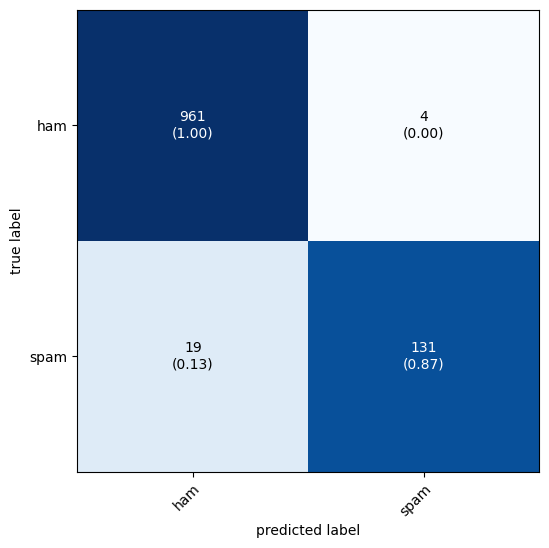

In [37]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

confmat = ConfusionMatrix(task="multiclass", num_classes=2)
conf_mat_tensor = confmat(all_preds, all_labels)
conf_mat_numpy = conf_mat_tensor.numpy()

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_numpy,
                                figsize=(6, 6),
                                cmap=plt.cm.Blues,
                                show_normed=True,
                                class_names=['ham', 'spam'])

plt.show()